## Setup

In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src.regex_pattern_generator import generate_regex_patterns


# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

In [18]:
PHRASES = ['Worker',
'Wage',
'UK / United Kingdom',
'Trade',
'Tax on Tips',
'Tariff',
'Strong',
'Security',
'Small Business',
'Overtime',
'Middle Class',
'Manufacturing',
'Investment',
'Infrastructure',
'Immigration',
'Home / Housing',
'Healthcare / health care',
'Gas',
'Family',
'Factory / Plant',
'Energy',
'Election',
'Economy',
'Democrat',
'China',
'Charlie / Kirk',
'Border',
'Biden',
'American Dream',
'AI / Artificial Intelligence']
SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PHRASES)

{'AI / Artificial Intelligence': "\\b(?:\\w+-)*(?:(?:ai|ais|ai's|ais'|artificial[\\s,\\-]+intelligence|artificial[\\s,\\-]+intelligences|artificial[\\s,\\-]+intelligence's|artificial[\\s,\\-]+intelligences'|artificials[\\s,\\-]+intelligence|artificials[\\s,\\-]+intelligences|artificials[\\s,\\-]+intelligence's|artificials[\\s,\\-]+intelligences'|artificial's[\\s,\\-]+intelligence|artificial's[\\s,\\-]+intelligences|artificial's[\\s,\\-]+intelligence's|artificial's[\\s,\\-]+intelligences'|artificials'[\\s,\\-]+intelligence|artificials'[\\s,\\-]+intelligences|artificials'[\\s,\\-]+intelligence's|artificials'[\\s,\\-]+intelligences'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'American Dream': "\\b(?:\\w+-)*(?:american[\\s,\\-]+dream|american[\\s,\\-]+dreams|american[\\s,\\-]+dream's|american[\\s,\\-]+dreams'|americans[\\s,\\-]+dream|americans[\\s,\\-]+dreams|americans[\\s,\\-]+dream's|americans[\\s,\\-]+dreams'|american's[\\s,\\-]+dream|american's[\\s,\\-]+dreams|american's[\\s,\\-]+dream's|america

In [19]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    
    return pd.DataFrame(results)


In [20]:
# Process transcripts
df = process_directory('../data-vance/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings
df = df[df['category'] != 'press briefing']

CATEGORY_OF_INTEREST = 'speech'
# Split data by date and category
category_mask = df['category'] == CATEGORY_OF_INTEREST

# Create interview dataframes
df_category = df[category_mask]

# Create non-interview dataframes
df_non_category = df[~category_mask]


# Print dataset statistics
print("Dataset Statistics:")
print(f"{CATEGORY_OF_INTEREST}: {len(df_category)}")
print(f"All: {len(df)}")

print("\nWord Count Statistics:")
print(F"{CATEGORY_OF_INTEREST}:")
print(f"Average length: {df_category['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print(f"{CATEGORY_OF_INTEREST}:")
if len(df_category) > 0:
    print(f"Range: {df_category['date'].min().strftime('%Y-%m-%d')} to {df_category['date'].max().strftime('%Y-%m-%d')}")
else:
    print("No interviews found")


Categories found in directory:
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- speech
Dataset Statistics:
speech: 9
All: 44

Word Count Statistics:
speech:
Average length: 3080 words

Date Ranges:
speech:
Range: 2024-03-16 to 2025-08-28


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)


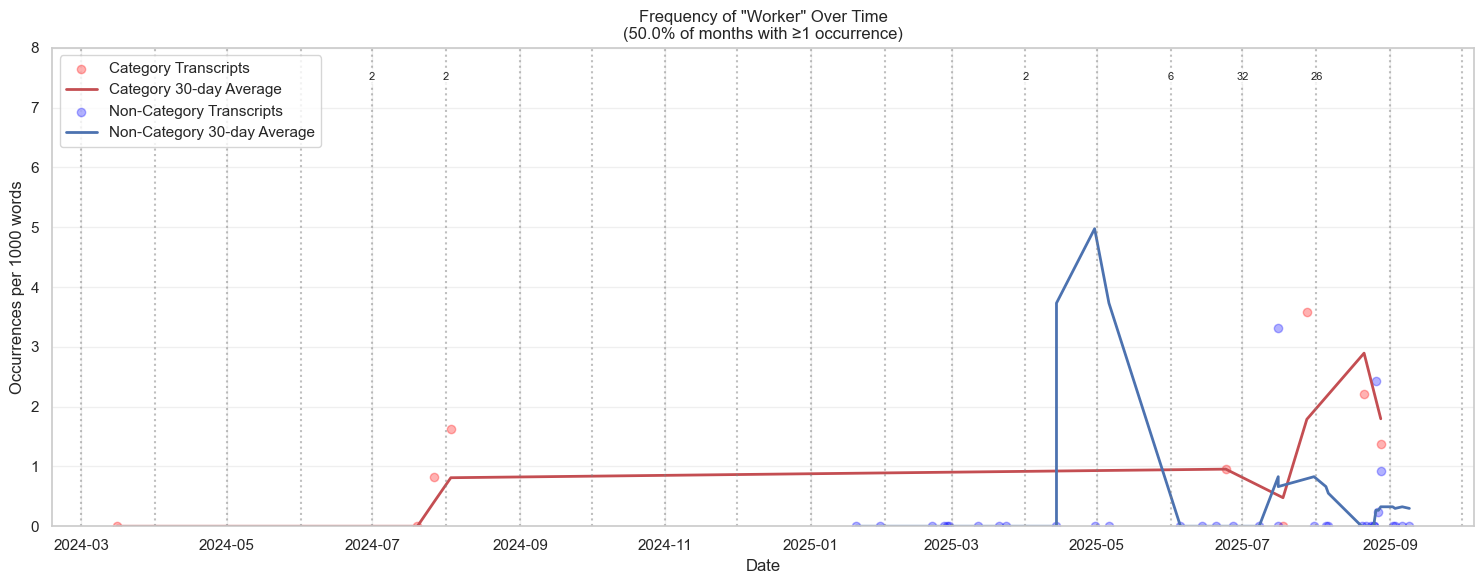


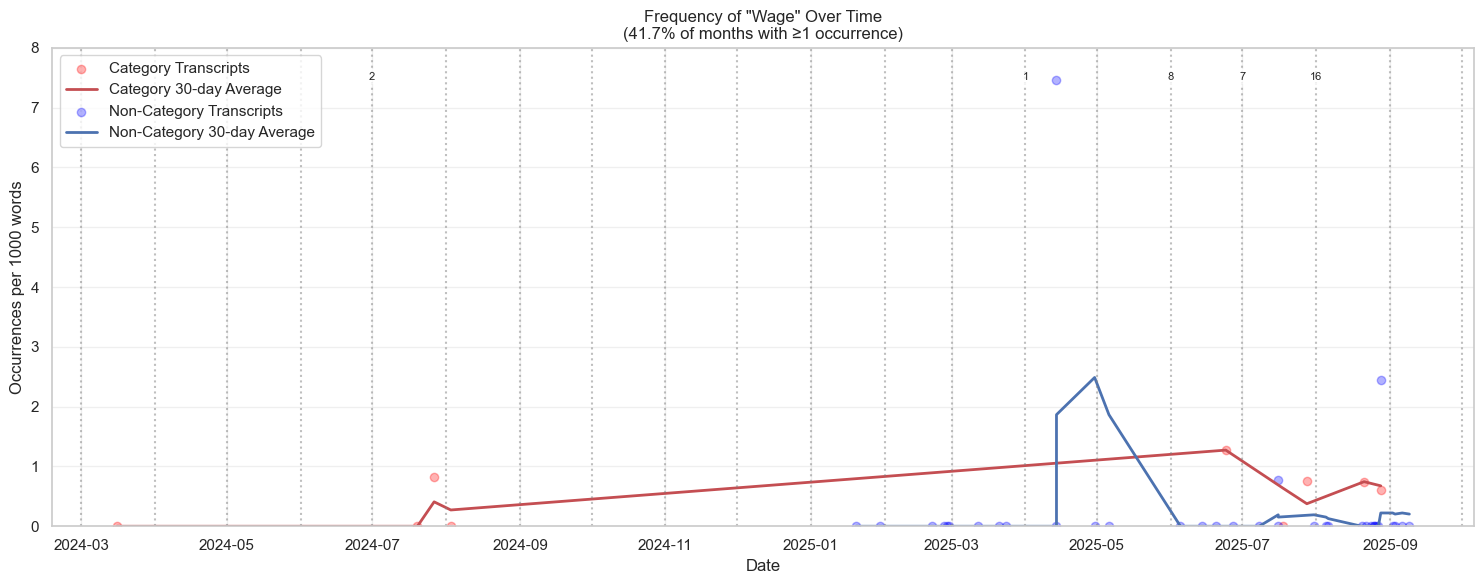


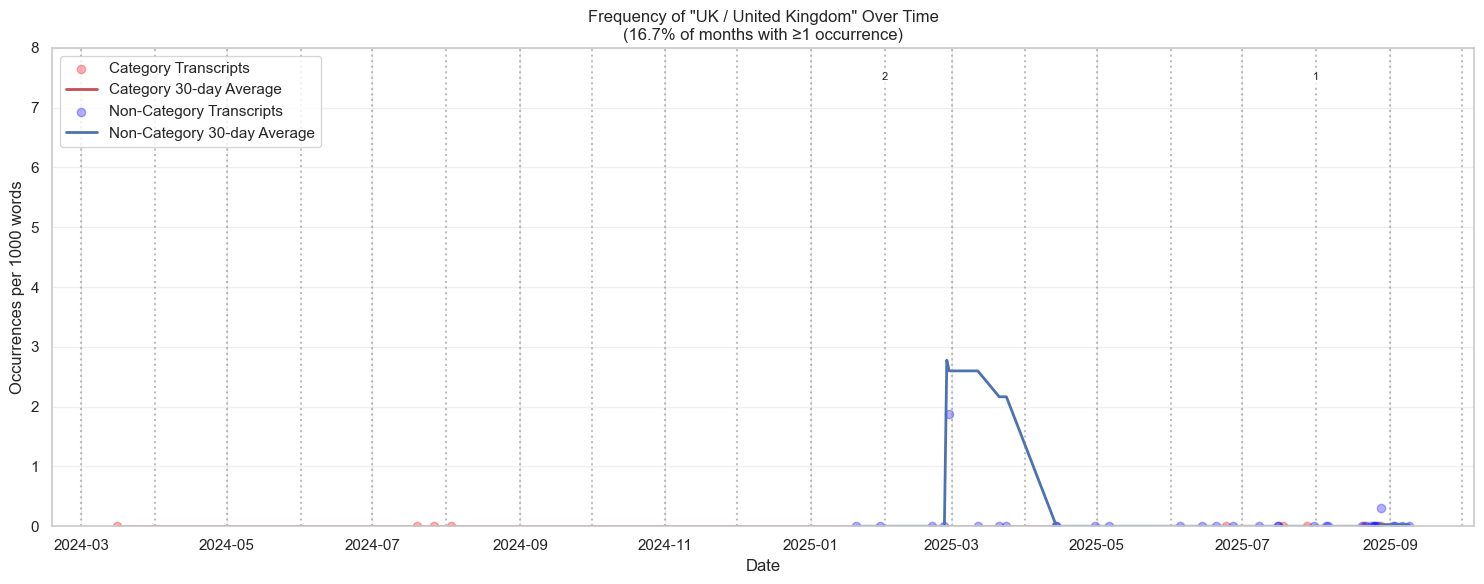


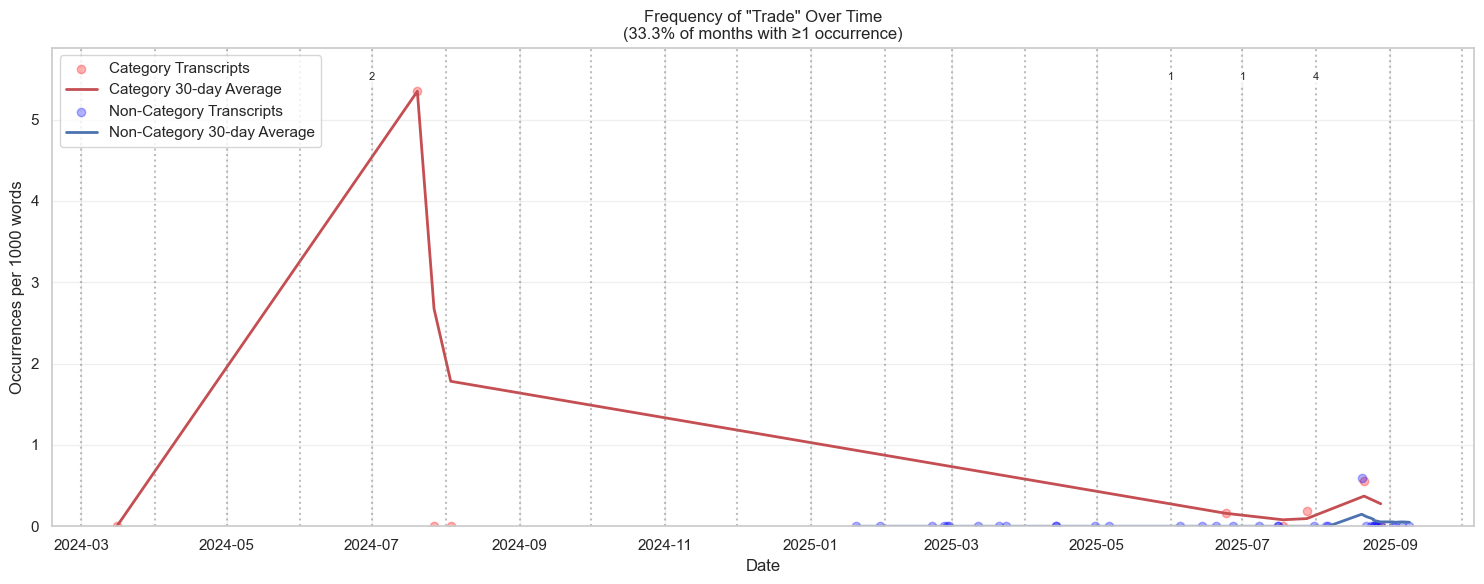


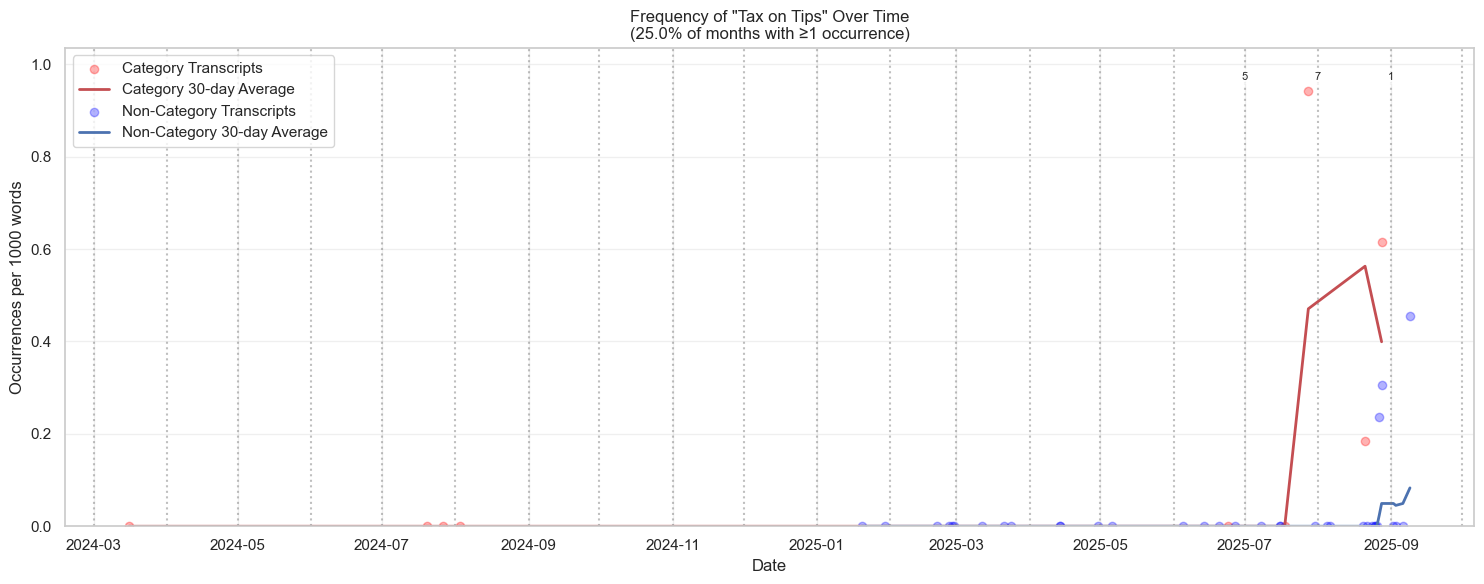


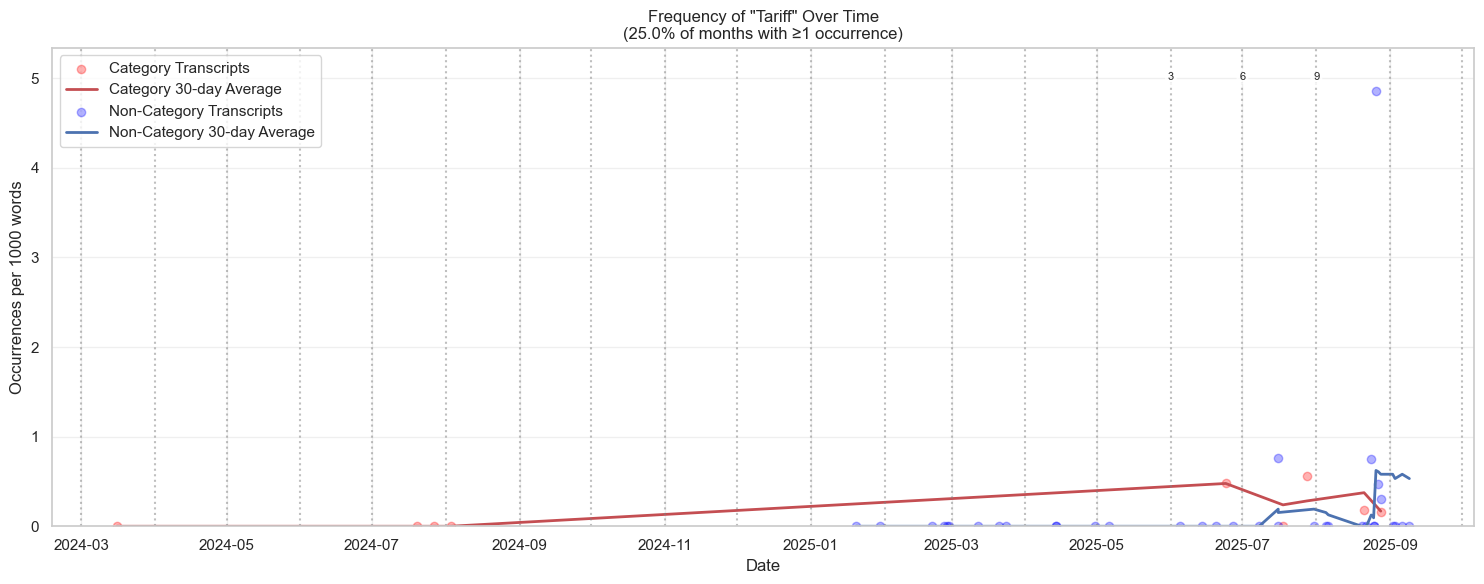


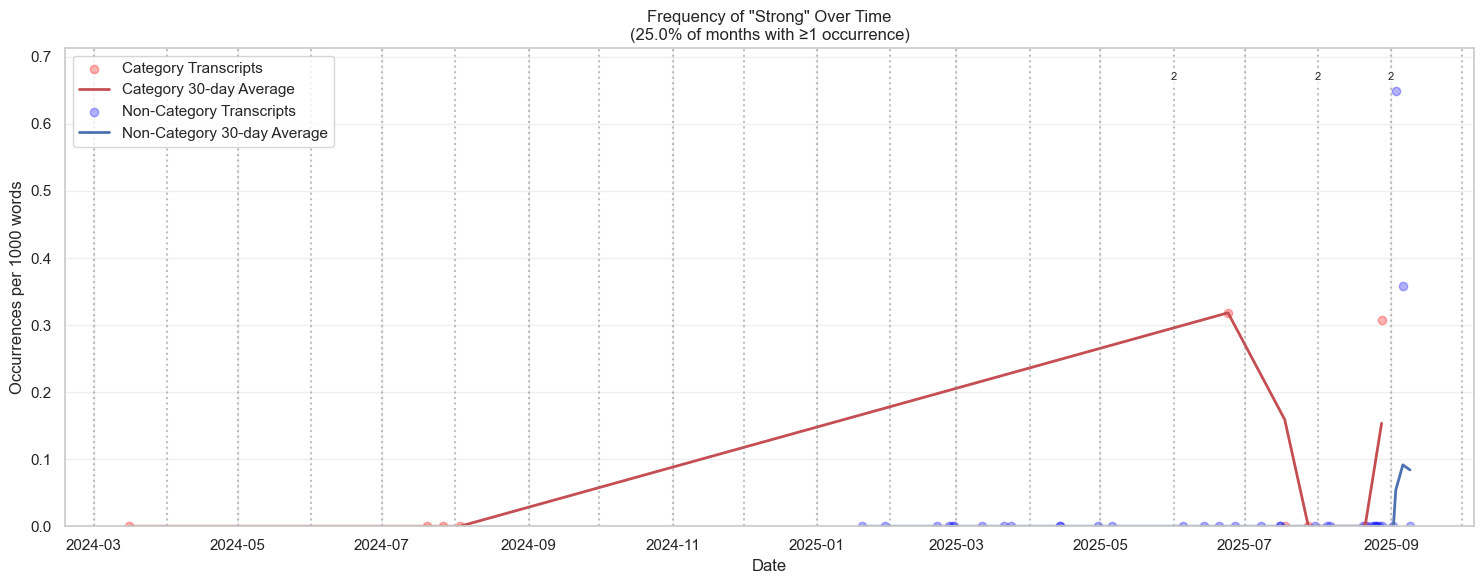


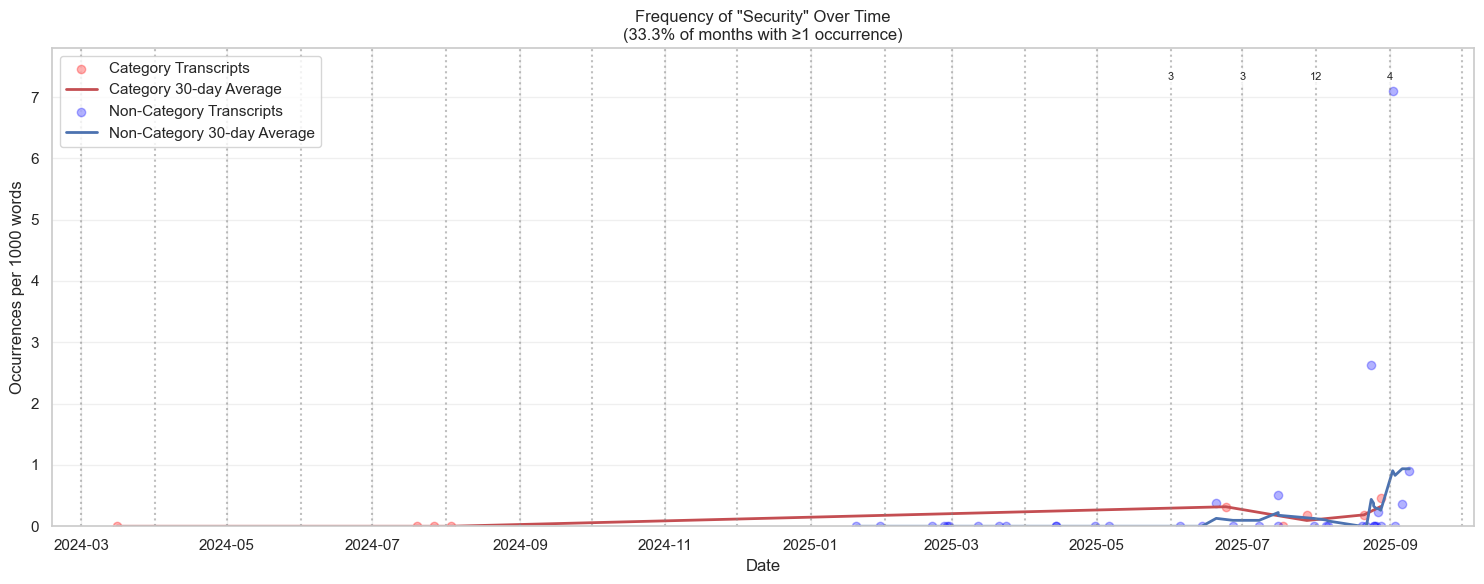


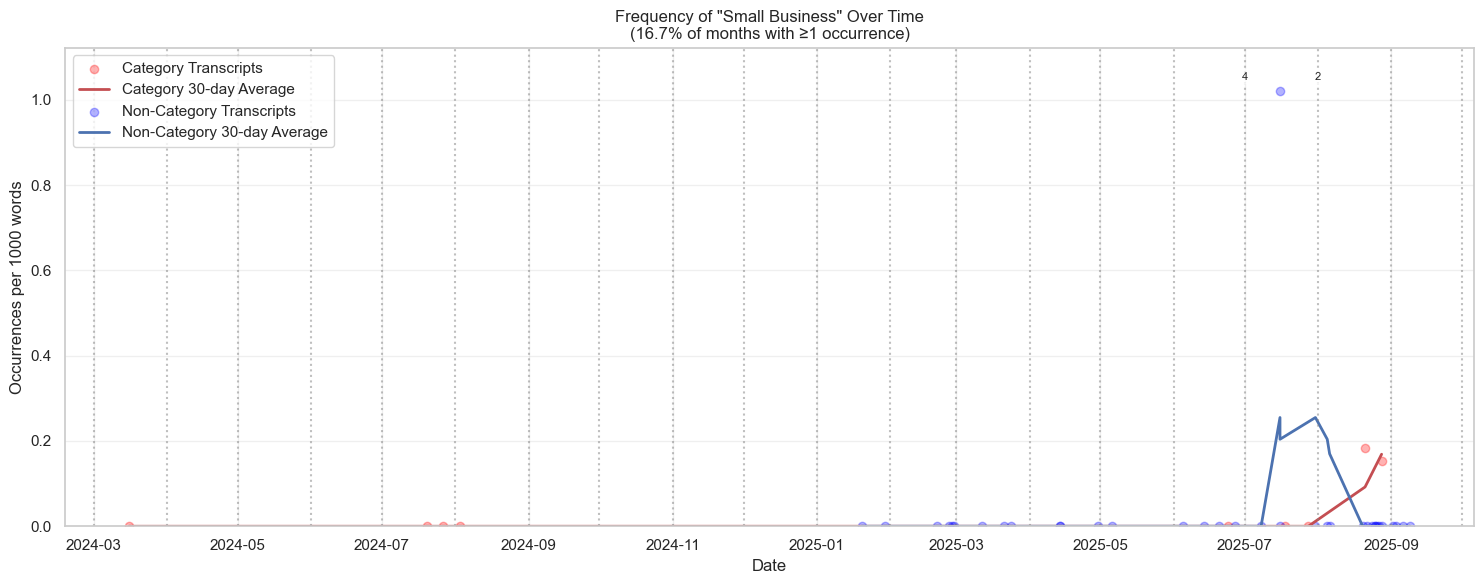


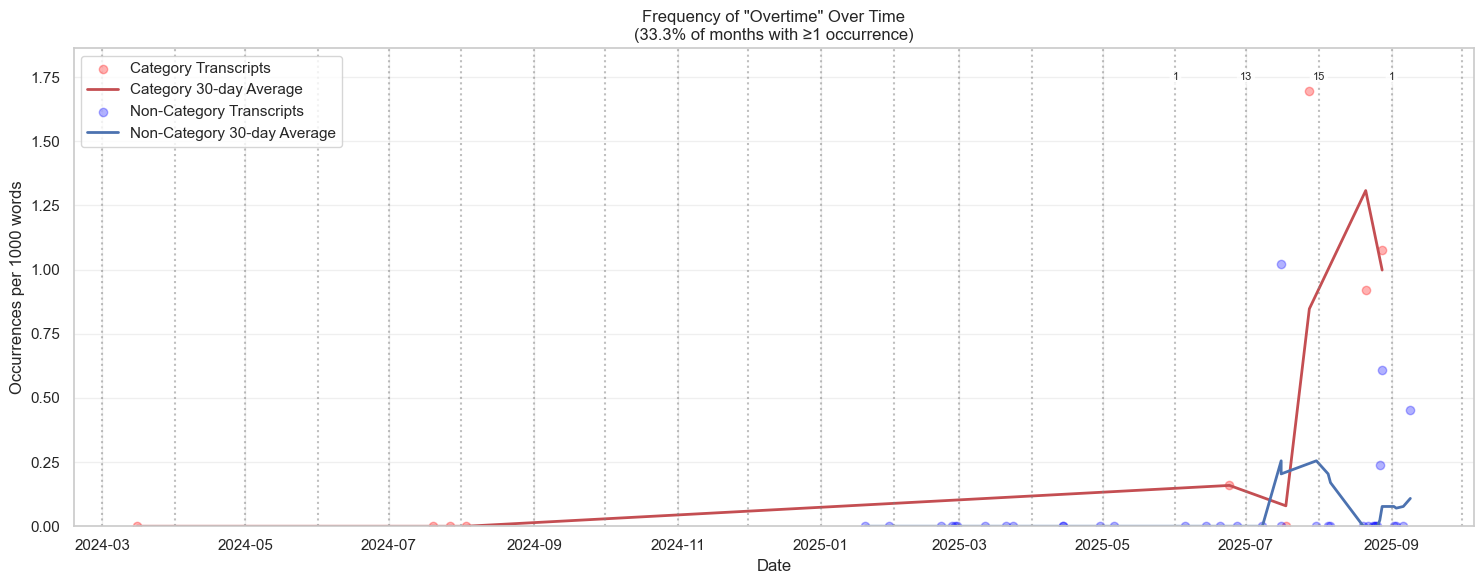


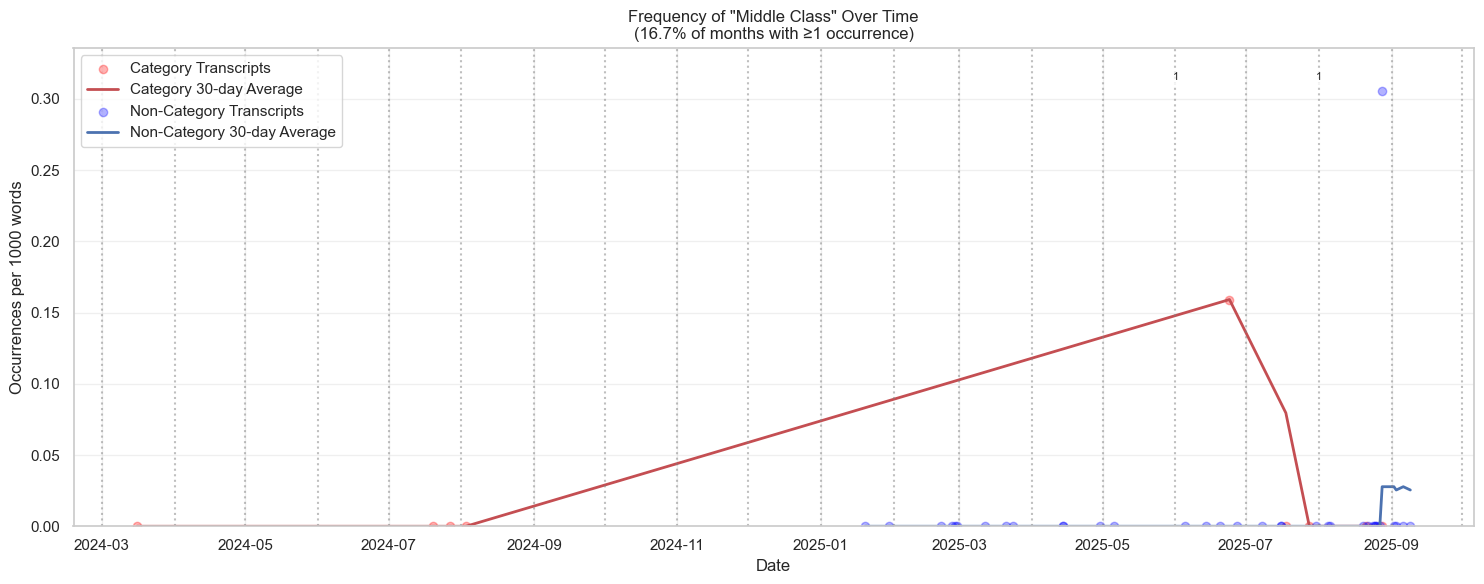


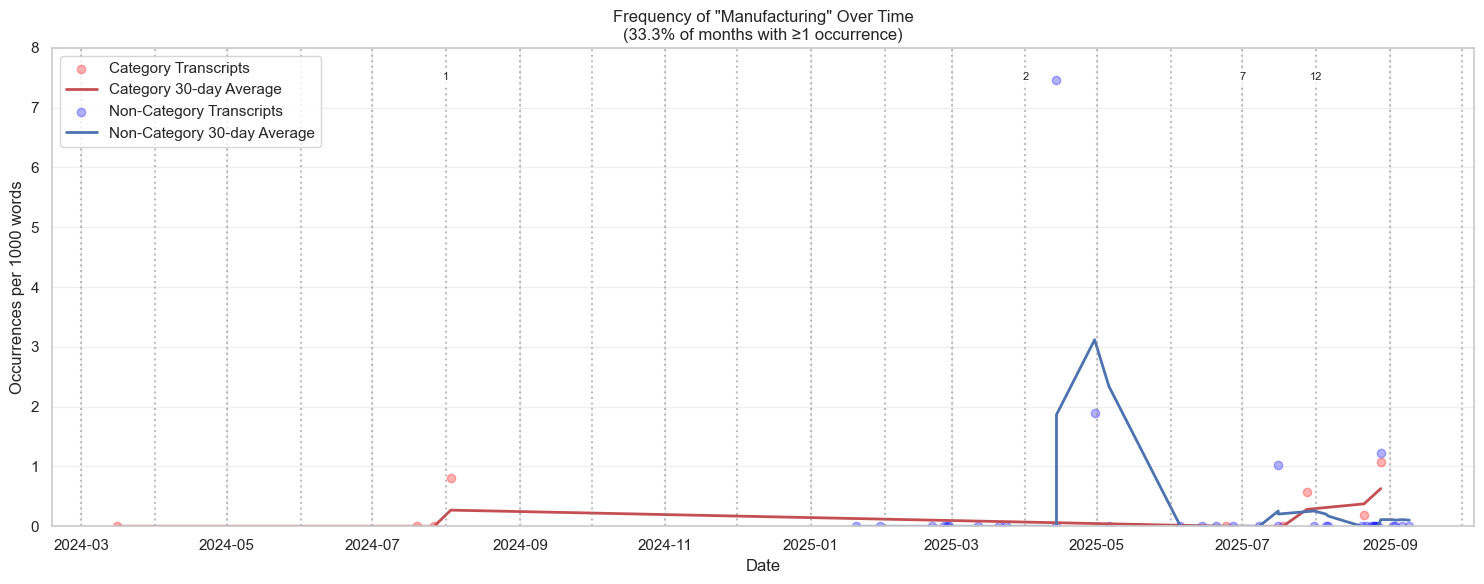


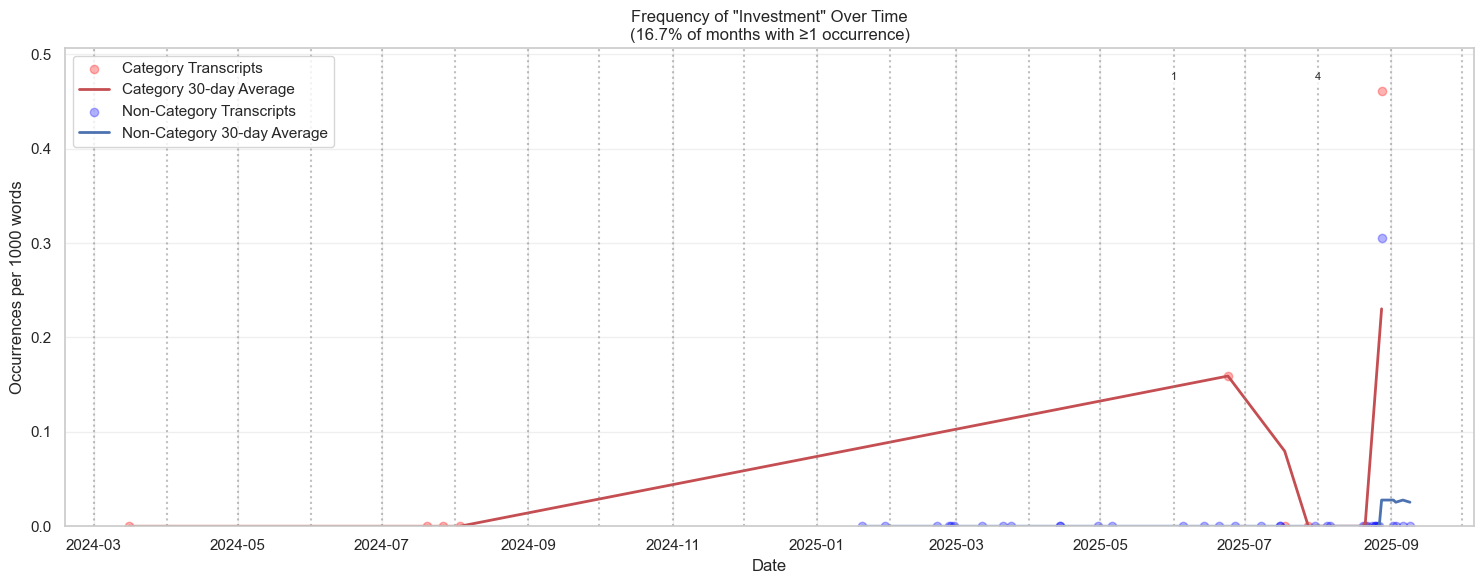


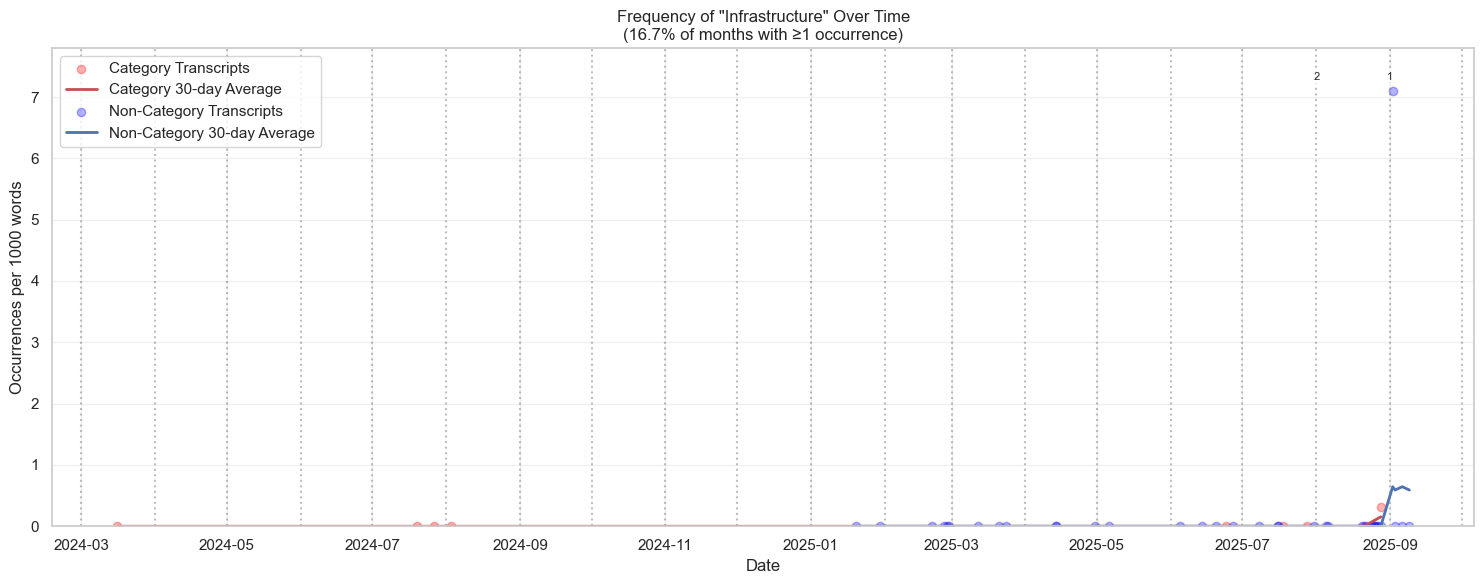


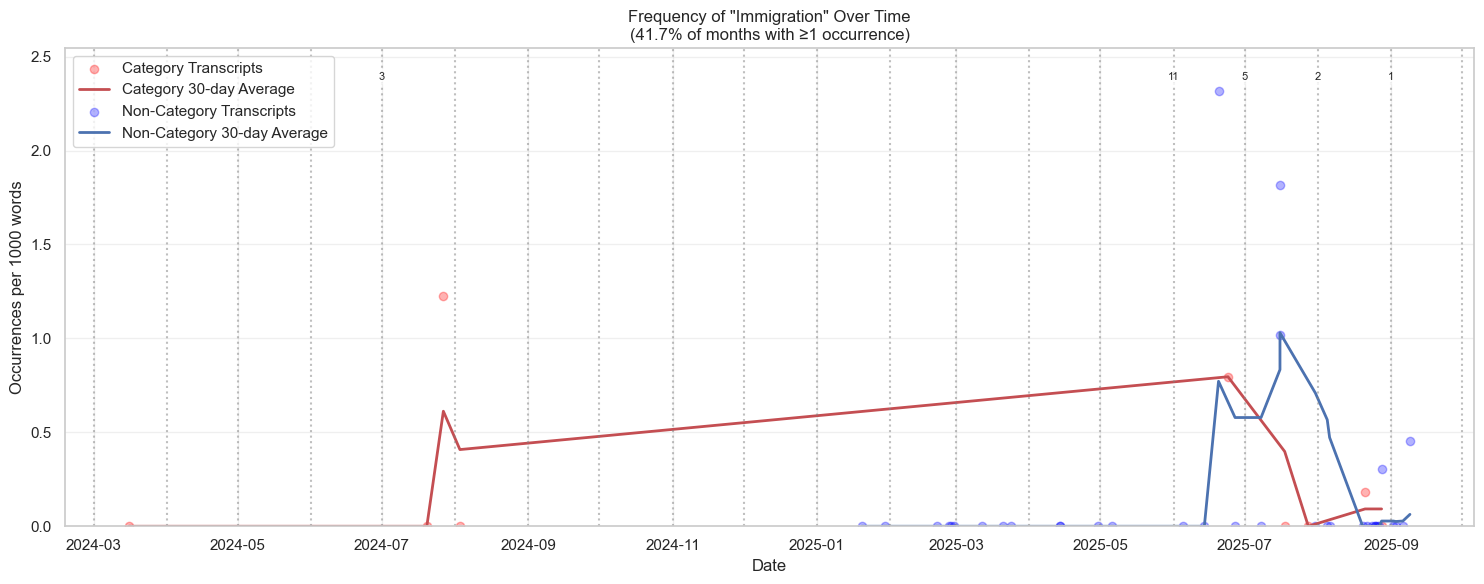


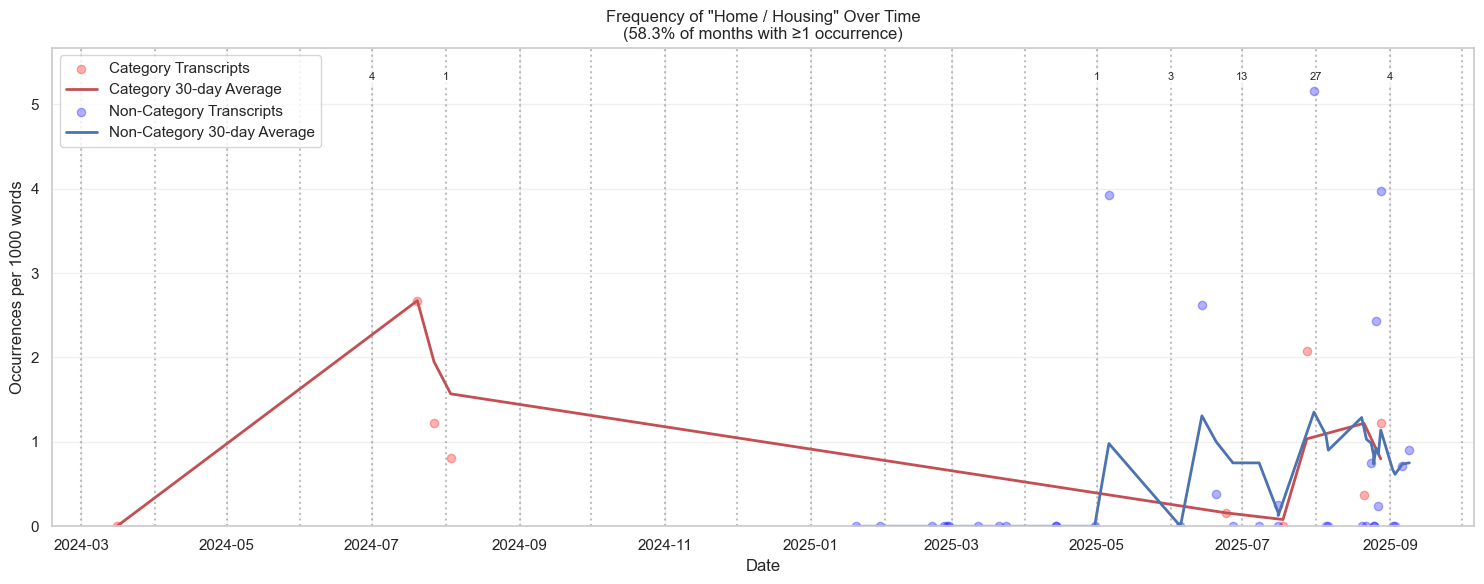


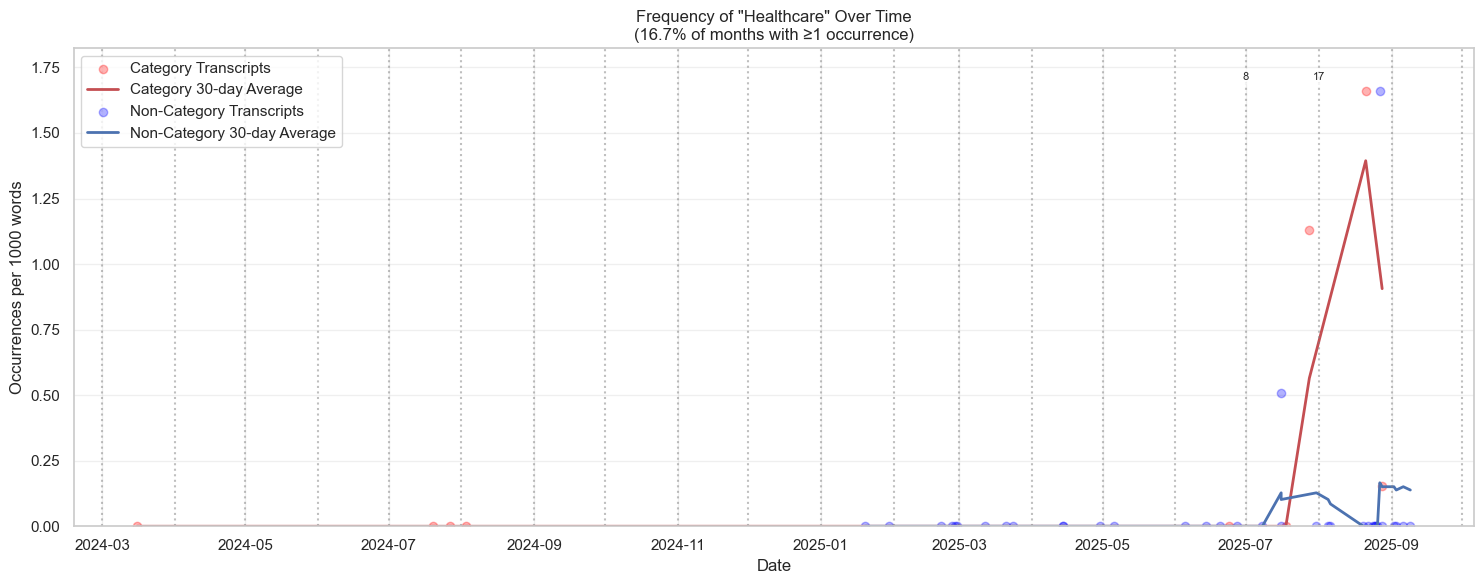


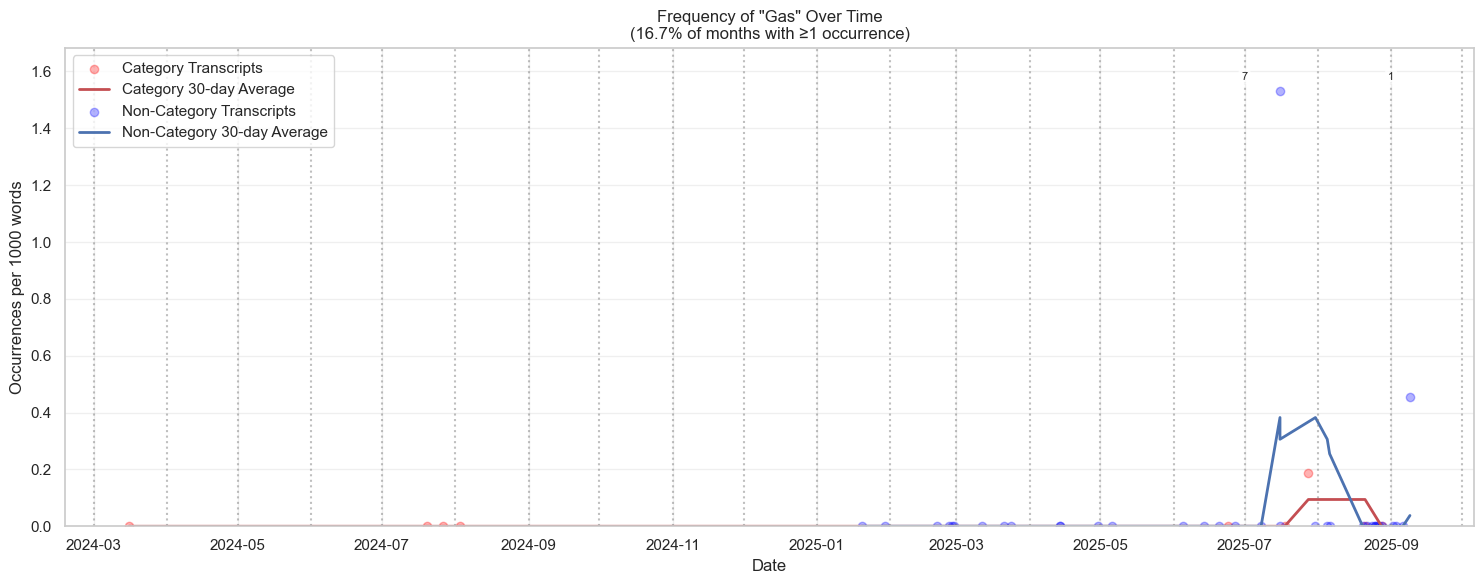


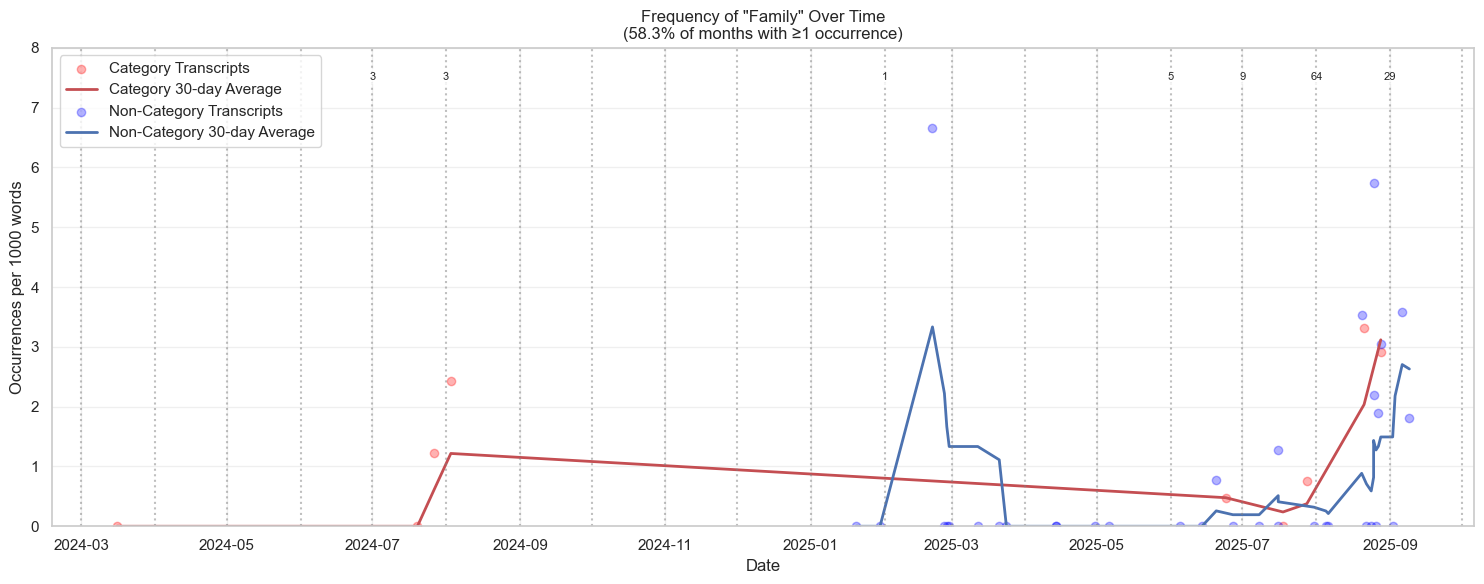


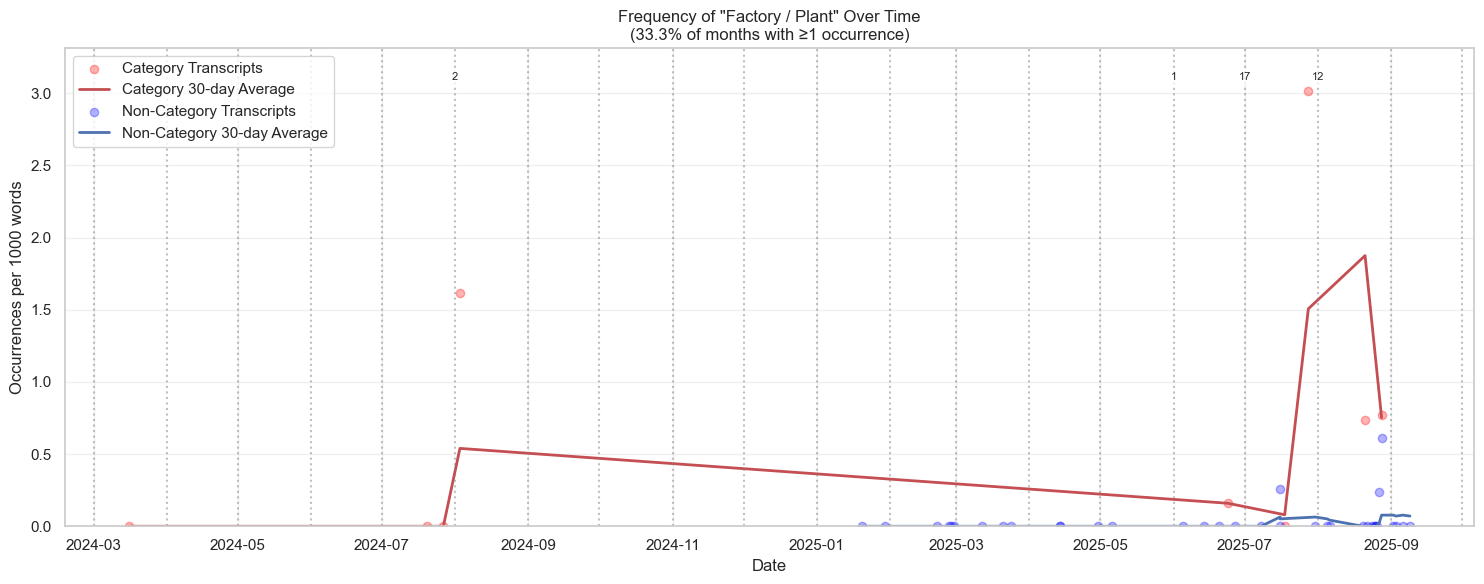


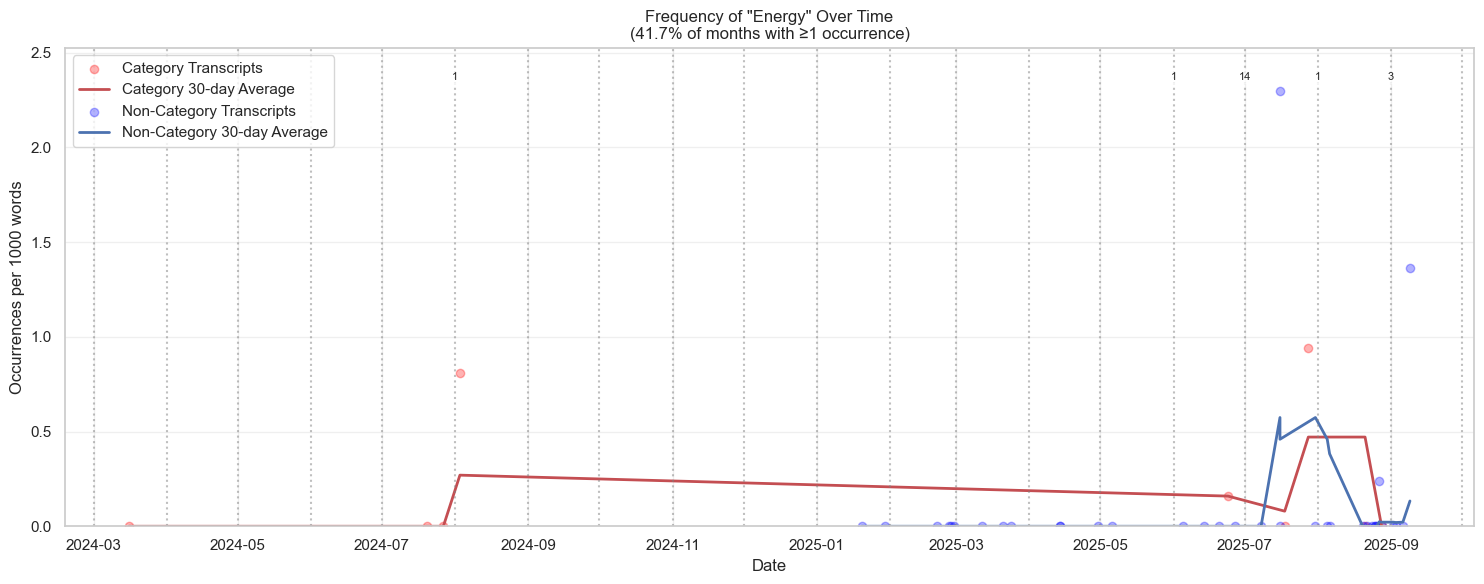


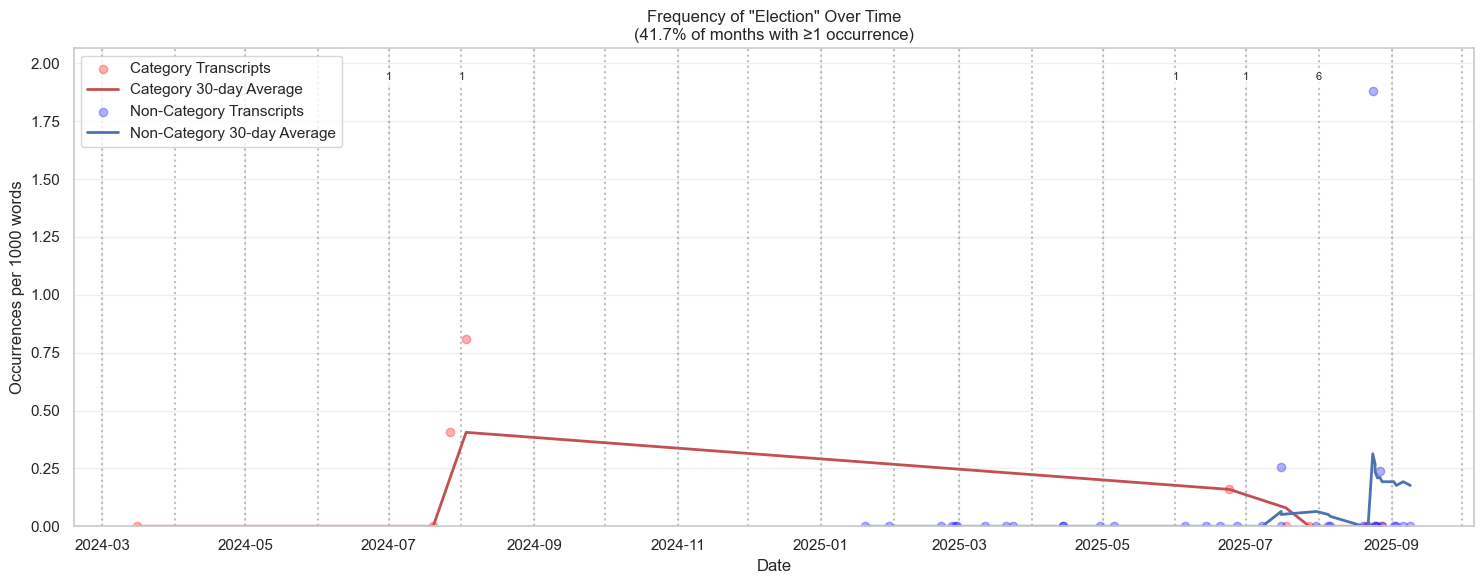


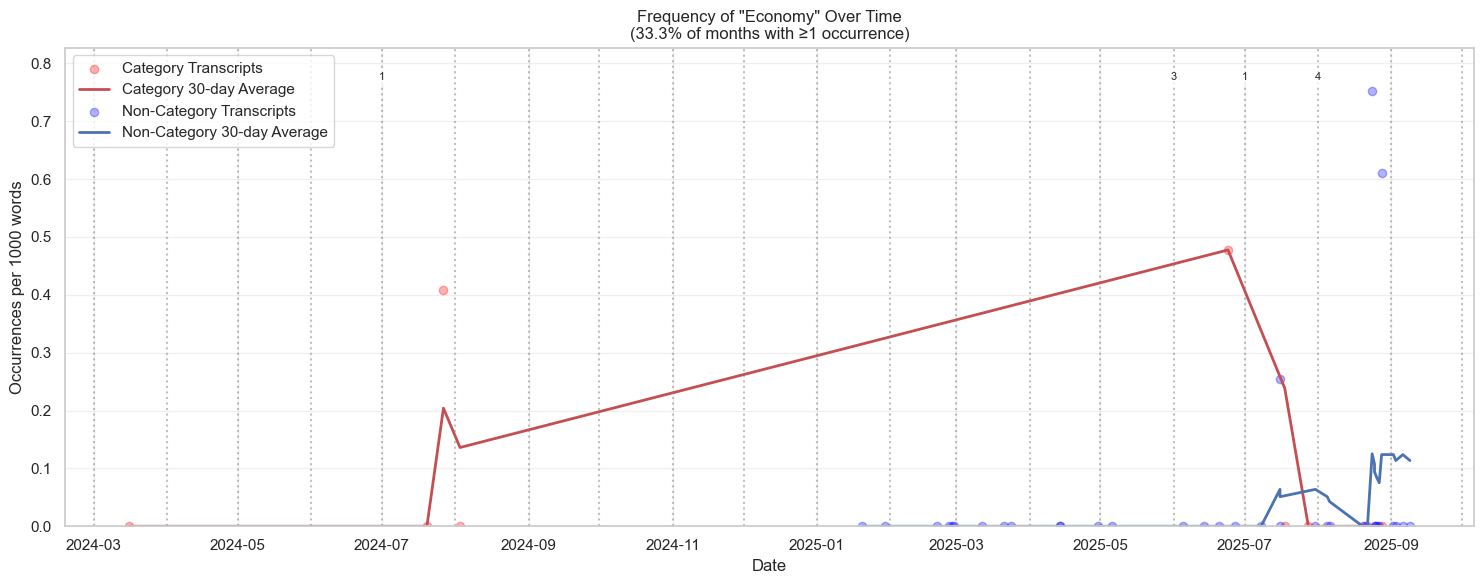


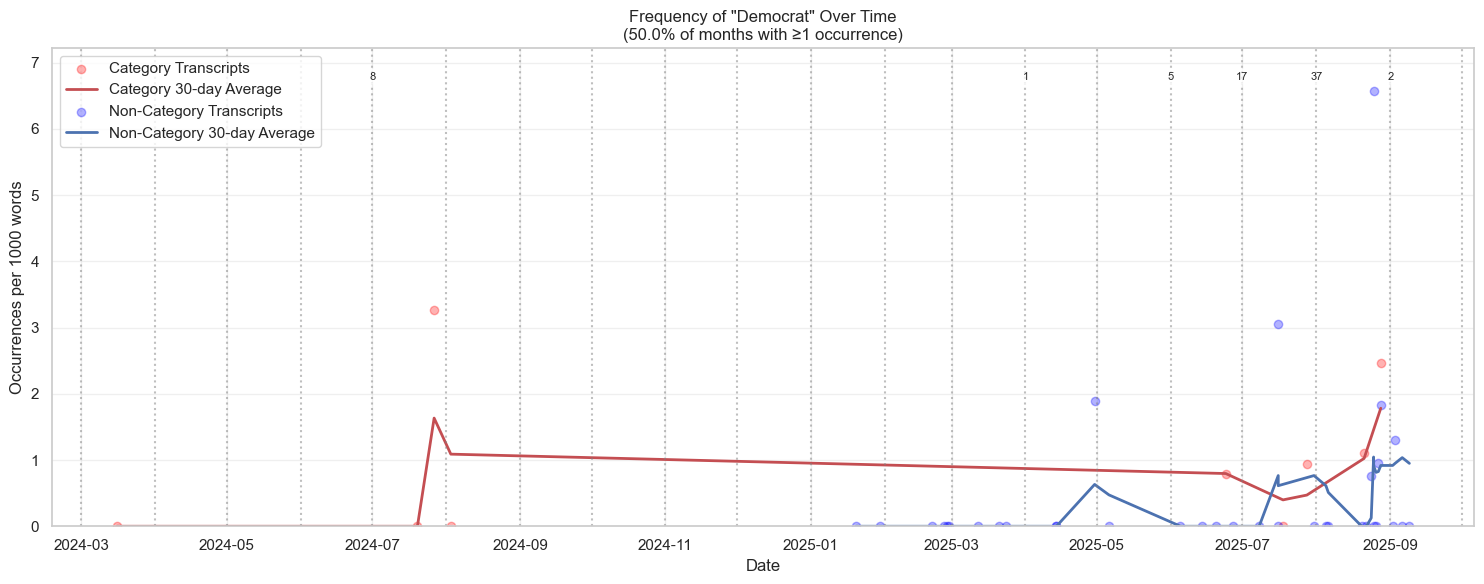


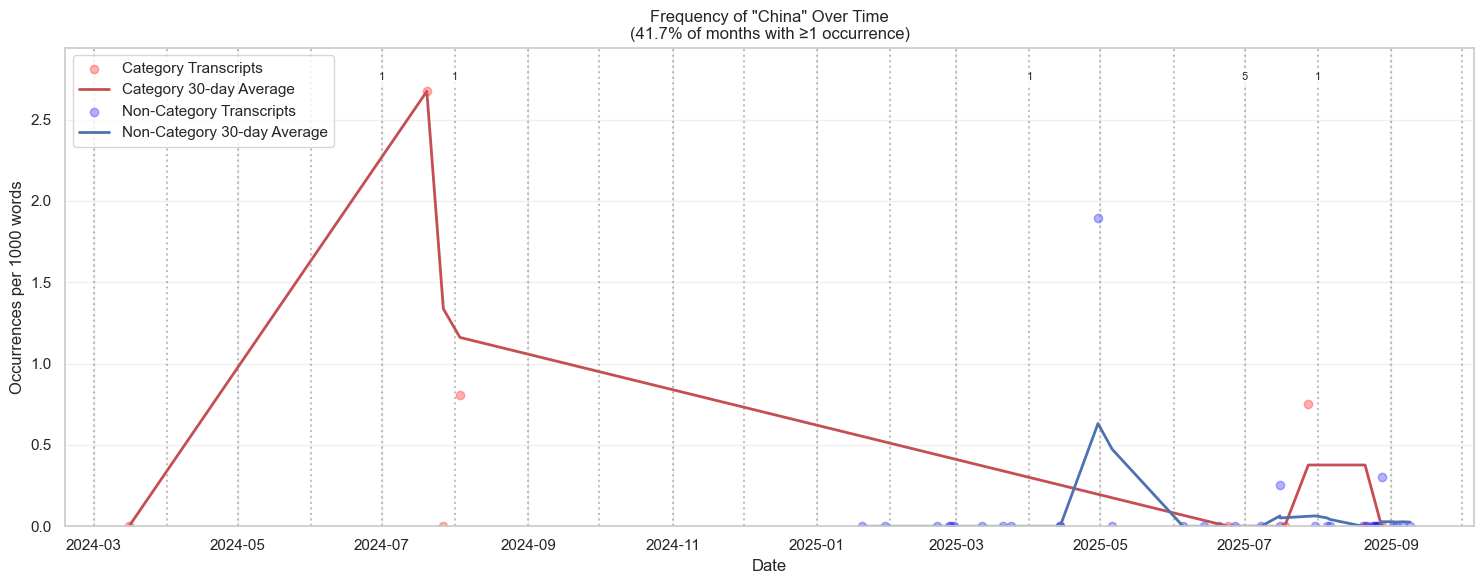

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_41062/1275468132.py:80: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)



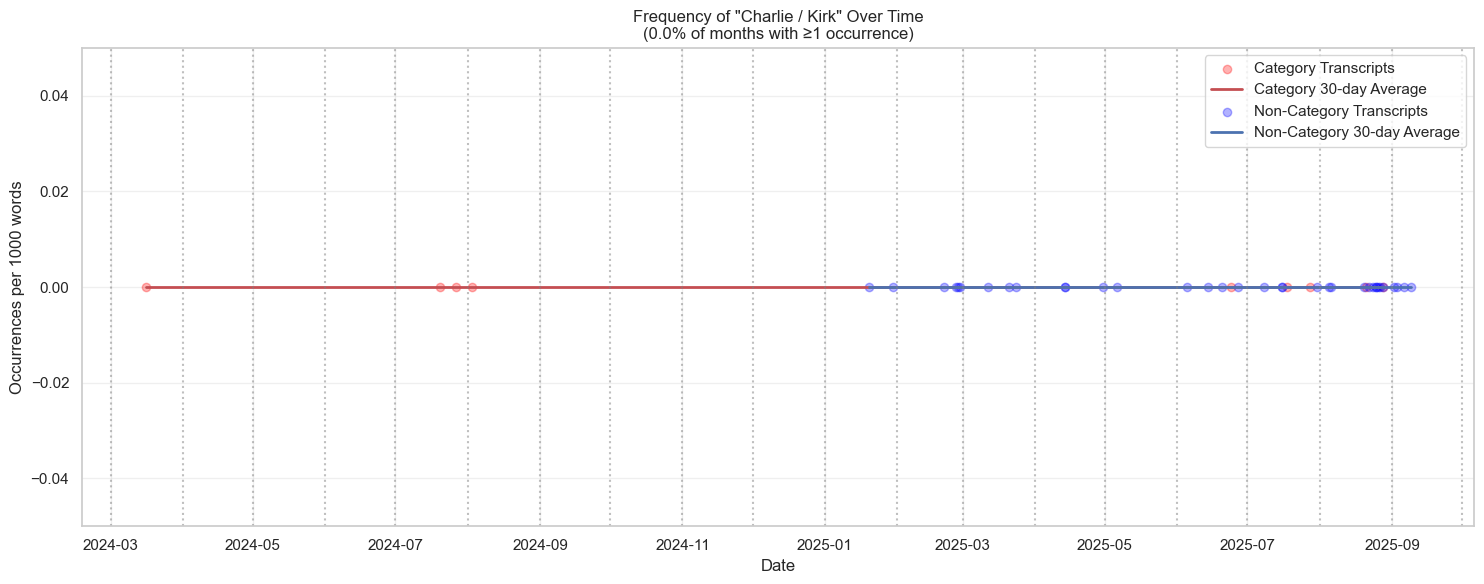


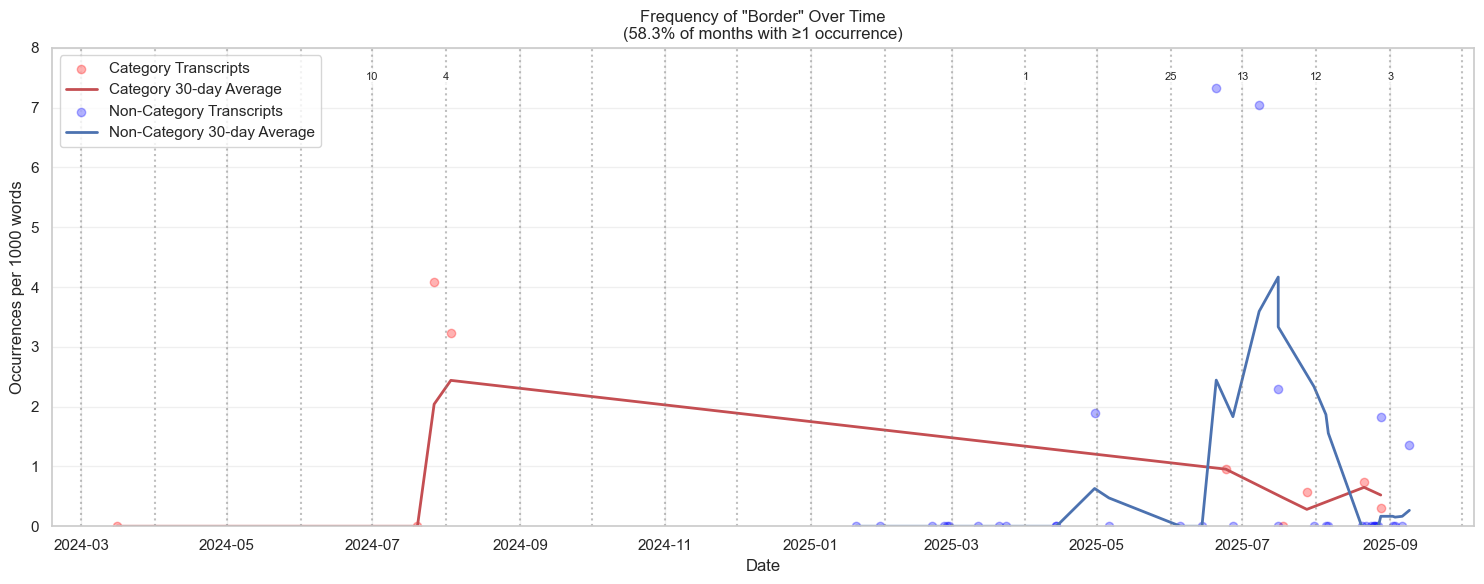


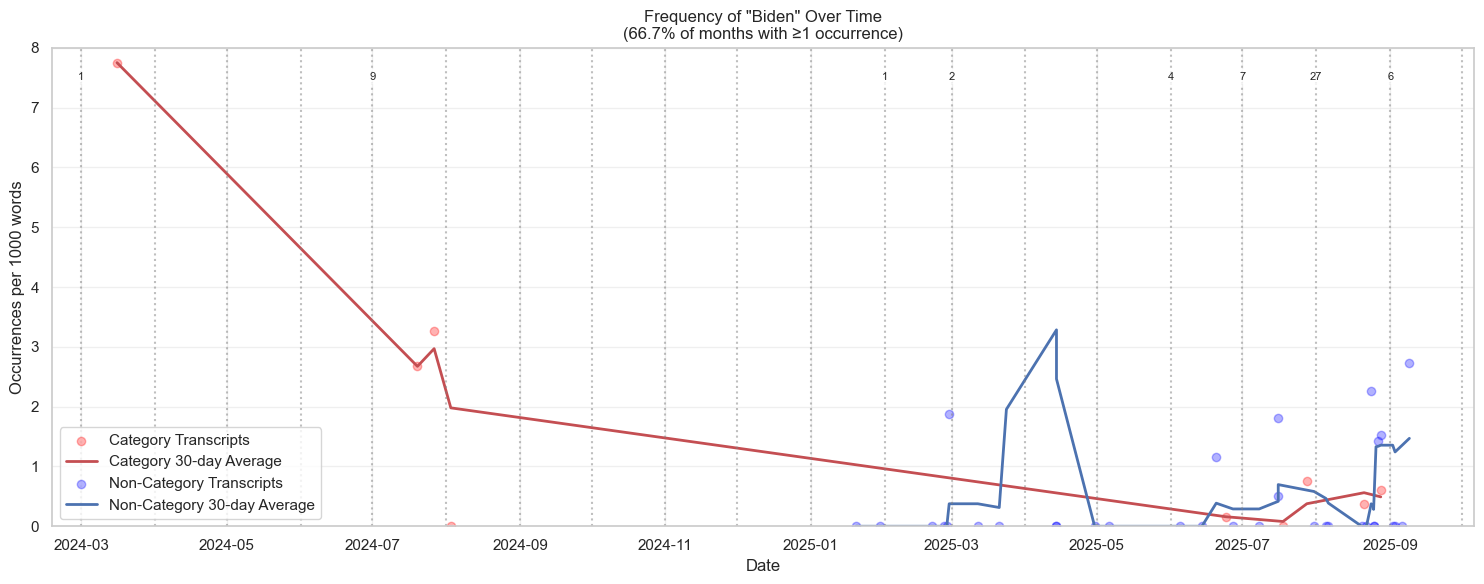


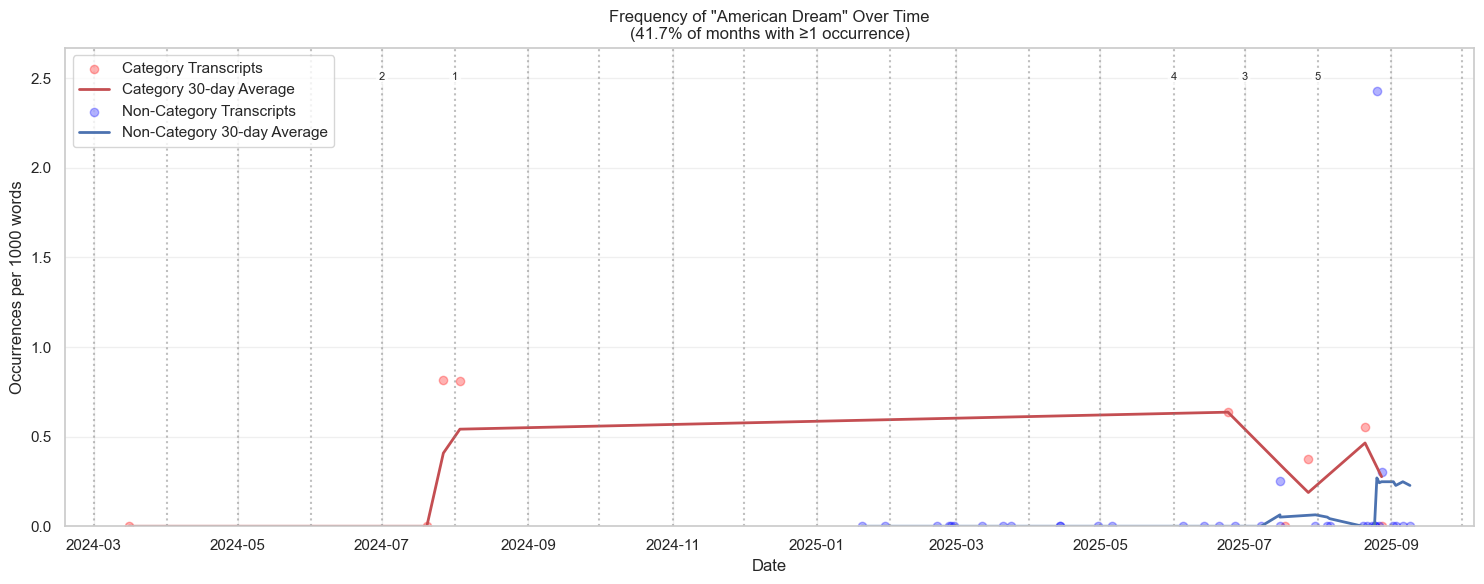


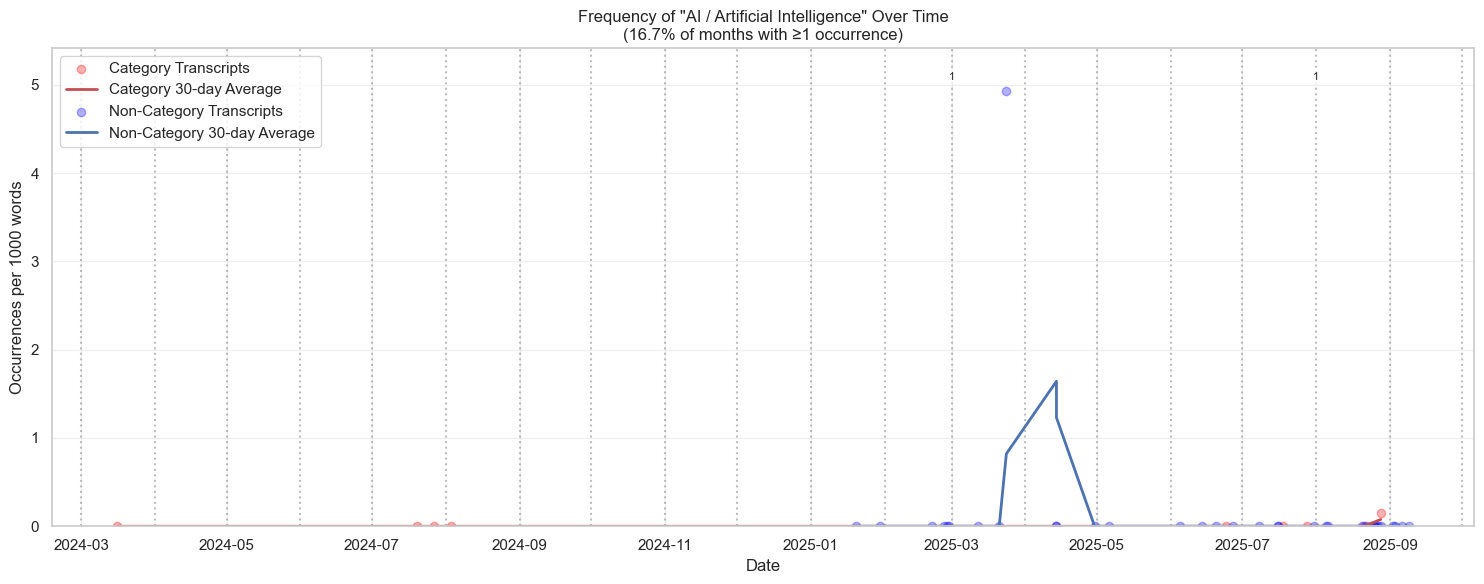

In [7]:
def plot_phrase_frequency_over_time(df_category, df_non_category, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for category and non-category"""
    from IPython.display import HTML, display
    
    plt.figure(figsize=(15, 6))
    
    # Process category data
    df_category = df_category.copy()
    df_category[f'{phrase}_freq'] = (df_category[phrase] / df_category['text_length']) * 1000
    category_series = df_category.set_index('date')[f'{phrase}_freq']
    category_rolling = category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-category data
    df_non_category = df_non_category.copy()
    df_non_category[f'{phrase}_freq'] = (df_non_category[phrase] / df_non_category['text_length']) * 1000
    non_category_series = df_non_category.set_index('date')[f'{phrase}_freq']
    non_category_rolling = non_category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot category data
    plt.scatter(category_series.index, category_series.values, alpha=0.3, color='red', label='Category Transcripts')
    plt.plot(category_rolling.index, category_rolling.values, 'r-', linewidth=2, label=f'Category {window}-day Average')
    
    # Plot non-category data
    plt.scatter(non_category_series.index, non_category_series.values, alpha=0.3, color='blue', label='Non-Category Transcripts')
    plt.plot(non_category_rolling.index, non_category_rolling.values, 'b-', linewidth=2, label=f'Non-Category {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add monthly vertical lines and counts
    combined_df = pd.concat([df_category, df_non_category])
    if not combined_df.empty:
        date_range = pd.date_range(
            start=combined_df['date'].min().replace(day=1),
            end=combined_df['date'].max() + pd.DateOffset(months=1),
            freq='MS'  # Month start
        )
        
        # Calculate monthly statistics
        combined_df['year_month'] = combined_df['date'].dt.to_period('M')
        monthly_stats = combined_df.groupby('year_month').agg({
            phrase: 'sum',
            'date': 'count'
        }).rename(columns={'date': 'transcript_count'})
        
        # Calculate % of months with 1+ occurrence
        months_with_occurrence = (monthly_stats[phrase] >= 1).sum()
        total_months = len(monthly_stats)
        pct_months_with_occurrence = (months_with_occurrence / total_months * 100) if total_months > 0 else 0
        
        # Add monthly vertical lines and counts
        for date in date_range:
            plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
            
            # Get monthly count for this date
            period = date.to_period('M')
            if period in monthly_stats.index:
                monthly_count = monthly_stats.loc[period, phrase]
                if monthly_count > 0:
                    # Position text at top of plot
                    ymax = min(8, max(
                        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
                        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
                    ) * 1.1)
                    plt.text(date, ymax * 0.95, str(int(monthly_count)), 
                            ha='center', va='top', fontsize=8, 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add percentage to title
        plt.title(f'Frequency of "{phrase}" Over Time\n({pct_months_with_occurrence:.1f}% of months with ≥1 occurrence)')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    
    # Save plot to base64 string for embedding in HTML
    import io
    import base64
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plot_data = base64.b64encode(buf.read()).decode()
    plt.close()  # Close the figure to free memory
    
    # Create collapsible HTML
    html = f"""
    <details>
        <summary style="cursor: pointer; font-weight: bold; font-size: 14px; padding: 5px;">
            📊 {phrase} - Frequency Over Time
        </summary>
        <div style="margin-top: 10px;">
            <img src="data:image/png;base64,{plot_data}" style="max-width: 100%; height: auto;">
        </div>
    </details>
    """
    
    display(HTML(html))

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    category_freq = (df_category[phrase].sum() / df_category['text_length'].sum()) * 1000 if not df_category.empty and df_category['text_length'].sum() > 0 else 0
    non_category_freq = (df_non_category[phrase].sum() / df_non_category['text_length'].sum()) * 1000 if not df_non_category.empty and df_non_category['text_length'].sum() > 0 else 0
    phrase_freqs[phrase] = (category_freq + non_category_freq) / 2

for phrase in phrase_freqs:
    plot_phrase_frequency_over_time(df_category, df_non_category, phrase)

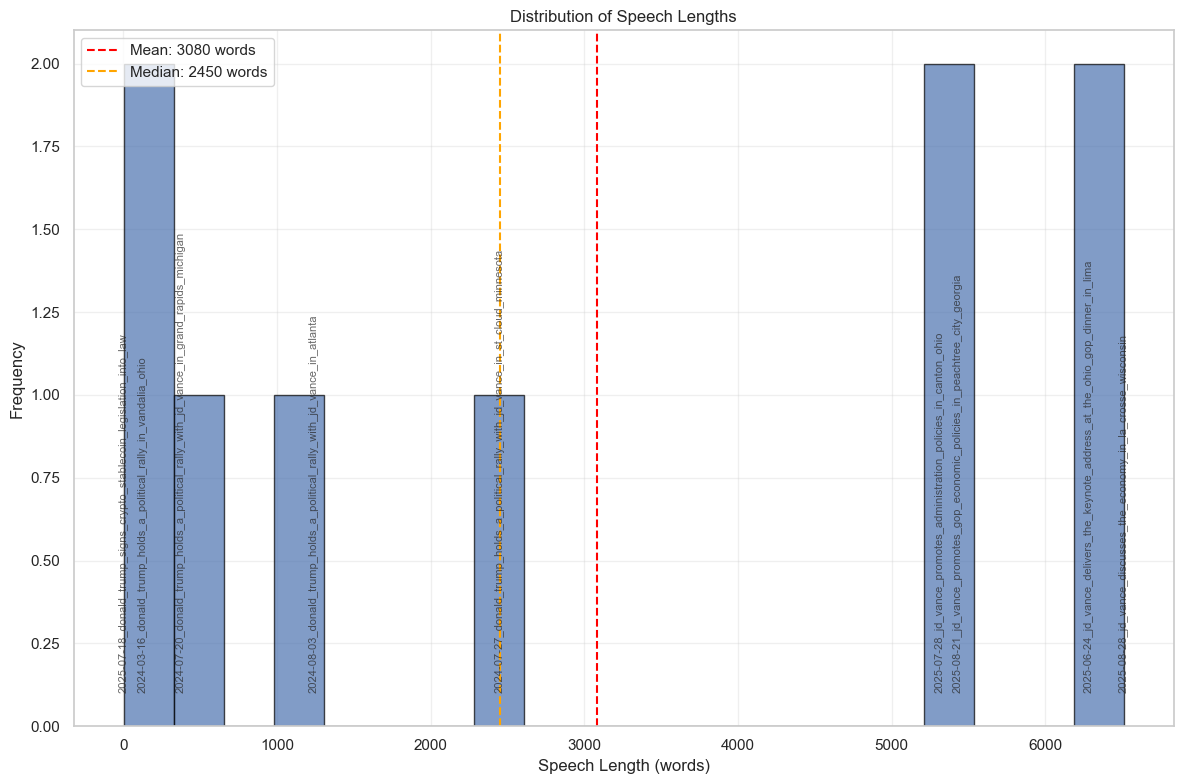

Speech length statistics:
Mean: 3080 words
Median: 2450 words
Min: 3 words
Max: 6511 words
Standard deviation: 2780 words


In [21]:
# Plot histogram of speech lengths
plt.figure(figsize=(12, 8))
plt.hist(df_category['text_length'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Speech Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Speech Lengths')
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
mean_length = df_category['text_length'].mean()
median_length = df_category['text_length'].median()
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.0f} words')
plt.axvline(median_length, color='orange', linestyle='--', label=f'Median: {median_length:.0f} words')

# Add file names as labels for each data point
for idx, row in df_category.iterrows():
    # Extract just the filename from the full path
    filename = row['file'].split('/')[-1] if '/' in row['file'] else row['file']
    # Remove .txt extension for cleaner display
    filename = filename.replace('.txt', '')
    
    # Add text label at the top of each bar (approximate position)
    plt.text(row['text_length'], 0.1, filename, 
             rotation=90, ha='center', va='bottom', fontsize=8, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

print(f"Speech length statistics:")
print(f"Mean: {mean_length:.0f} words")
print(f"Median: {median_length:.0f} words")
print(f"Min: {df_category['text_length'].min():.0f} words")
print(f"Max: {df_category['text_length'].max():.0f} words")
print(f"Standard deviation: {df_category['text_length'].std():.0f} words")



## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [22]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1)
        })
    
    return pd.DataFrame(predictions)

# length = df_category['text_length'].mean()
length = 5750
print(f"Using length: {length} words")

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_interviews = calculate_poisson_predictions(df_category, length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on speeches:")
display(format_prediction_table(predictions_interviews, 'interviews'))

Using length: 5750 words
Predictions based on all appearances:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
18,Family,11.21,100.0%,1.95,114
0,Worker,6.88,100.0%,1.20,70
23,Democrat,6.88,100.0%,1.20,70
26,Border,6.69,100.0%,1.16,68
27,Biden,5.61,100.0%,0.97,57
15,Home / Housing,5.21,99.0%,0.91,53
16,Healthcare / health care,4.82,99.0%,0.84,49
1,Wage,3.34,96.0%,0.58,34
19,Factory / Plant,3.15,96.0%,0.55,32
9,Overtime,2.95,95.0%,0.51,30



Predictions based on speeches:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
0,Worker,10.37,100.0%,1.80,50
18,Family,10.37,100.0%,1.80,50
16,Healthcare / health care,8.30,100.0%,1.44,40
23,Democrat,8.30,100.0%,1.44,40
26,Border,6.01,100.0%,1.05,29
19,Factory / Plant,5.81,100.0%,1.01,28
15,Home / Housing,5.60,100.0%,0.97,27
9,Overtime,4.56,99.0%,0.79,22
1,Wage,4.56,99.0%,0.79,22
27,Biden,4.36,99.0%,0.76,21


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [25]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

# Calculate predictions using both models
# avg_speech_length = df['text_length'].mean() 
avg_speech_length = 5750

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on interviews:")
nb_predictions_interviews = calculate_negative_binomial_predictions(df_category, avg_speech_length)
display(format_prediction_table(nb_predictions_interviews))

Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
18,Family,11.21,0.94,144.88,91.0%
0,Worker,6.88,0.27,184.93,58.4%
23,Democrat,6.88,1.05,52.20,88.0%
26,Border,6.69,0.51,95.07,73.9%
27,Biden,5.61,0.17,186.31,45.6%
15,Home / Housing,5.21,0.58,51.98,73.7%
16,Healthcare / health care,4.82,2.66,13.53,93.6%
1,Wage,3.34,0.26,46.90,49.2%
19,Factory / Plant,3.15,1.61,9.31,82.5%
9,Overtime,2.95,6.04,4.39,90.9%


Negative Binomial Predictions based on interviews:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
0,Worker,10.37,2.92,47.13,98.8%
18,Family,10.37,2.27,57.74,98.0%
16,Healthcare / health care,8.30,1.88,44.87,95.8%
23,Democrat,8.30,1.79,46.66,95.5%
26,Border,6.02,0.52,75.02,73.4%
19,Factory / Plant,5.81,1.16,34.92,87.5%
15,Home / Housing,5.60,1.30,29.63,88.6%
9,Overtime,4.56,2.34,13.45,92.1%
1,Wage,4.56,7.03,7.53,97.0%
27,Biden,4.36,0.10,214.98,31.6%


## Recent Usage in context

In [26]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Worker' ===

Date: 2025-08-28 (speech)
Context: ...ertime because we believe that if you spend an extra hour at work, the government ought to keep its hands the hell out of your pocket.

Is that right? We know about 5 percent, about 1 in 20 Wisconsin workers rely on tips to bring home the bacon for themselves and their families. How nice is it to have a president of United States and Republican majorities in Congress that cut taxes on tips instead of for...

Date: 2025-08-28 (speech)
Context: ...ates of America, if you're trying to earn a decent living right here at home, we are going to fight for you every single day.

But if you build crap overseas and try to undercut the wages of American workers, you're going to pay a big fat tariff before you bring it back into the United States of America. Now I was talking with a Fox News host earlier and I'm going to embarrass him a little bit. I'm going ...

Date: 2025-08-28 (speech)
Context: ...t allows these folks to su

## Per-Speech Frequencies


In [24]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}
for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    category_pct = (df_category[phrase] >= 1).mean() * 100
    non_category_pct = (df_non_category[phrase] >= 1).mean() * 100
    # Filter for category appearances with >3000 words
    category_long = df_category[df_category['text_length'] > 3000]
    category_long_pct = (category_long[phrase] >= 1).mean() * 100 if not category_long.empty else 0
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        '{CATEGORY_OF_INTEREST} Only': category_pct,
        '{CATEGORY_OF_INTEREST} >3000 words': category_long_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    '{CATEGORY_OF_INTEREST} Only': '{:.1f}%'.format,
    '{CATEGORY_OF_INTEREST} >3000 words': '{:.1f}%'.format,
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


,All Appearances,{CATEGORY_OF_INTEREST} Only,{CATEGORY_OF_INTEREST} >3000 words
Phrase,,,
Home / Housing,40.9%,77.8%,100.0%
Biden,38.6%,77.8%,100.0%
Family,38.6%,66.7%,100.0%
Border,27.3%,66.7%,100.0%
Democrat,27.3%,55.6%,100.0%
Security,25.0%,44.4%,100.0%
Worker,25.0%,66.7%,100.0%
Tariff,20.5%,44.4%,100.0%
Overtime,18.2%,44.4%,100.0%


In [12]:
# Filter for the specific file and show phrase occurrences
specific_file = "2020-10-15_rachel_maddow"
file_data = df[df['file'].str.contains(specific_file, na=False)]

if not file_data.empty:
    # Get all phrase columns (excluding metadata columns)
    phrase_cols = [col for col in df.columns if col in SEARCH_PHRASES.keys()]
    
    # Create a summary of phrase occurrences for this file
    file_summary = file_data[['file'] + phrase_cols].copy()
    
    # Transpose to show phrases as rows
    phrase_occurrences = file_summary.set_index('file').T
    phrase_occurrences.columns = ['Occurrences']
    phrase_occurrences = phrase_occurrences.sort_values('Occurrences', ascending=False)
    
    print(f"Phrase occurrences in {specific_file}:")
    display(phrase_occurrences)
    
    # Also show file metadata
    print(f"\nFile details:")
    print(f"Text length: {file_data['text_length'].iloc[0]:,} words")
    print(f"Category: {file_data['category'].iloc[0]}")
    print(f"Date: {file_data['date'].iloc[0]}")
else:
    print(f"No file found containing '{specific_file}' in the filename")


Phrase occurrences in 2020-10-15_rachel_maddow:


,Occurrences
Election,12
Biden,6
Fight,4
Trump,4
California,1
Campaign,1
Zohran / Mamdani,0
Abortion,0
Book,0
Charlie / Kirk,0



File details:
Text length: 3,354 words
Category: interview
Date: 2020-10-15 00:00:00
